Contour plot of ln(evidence) for loss against number of layers\
for limited and not limited thickness

ploting ln(evidence) for changes in $Dq/q$ vs $\lambda$, with $\lambda$ scaleing dR

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
    print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    plt.plot(xall,res["logz"])
    plt.title("ln(evidence) log scaled vs -ln(X)")
    # plt.yscale("log")
    plt.figure(figI)
    figI+=1
    plt.plot(interesting[0],interesting[1])
    plt.title(r"interesting values ln(evidence)  vs -ln(X) $\geq %d$" % interestingNo)
    if len(useable)>=2:
        plt.figure(figI)
        figI+=1
        plt.plot(useable[0],useable[1])
        plt.title(r"usful values ln(%.3f<evidence $\leq$ %.3f)  vs -ln(X)"%(useAbleLow,useAbleHigh))
    print(figI)
    return figI

In [3]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
realStructure = layers[0]
for layer in layers[1:]:
    realStructure|=layer
print("done")

done


done


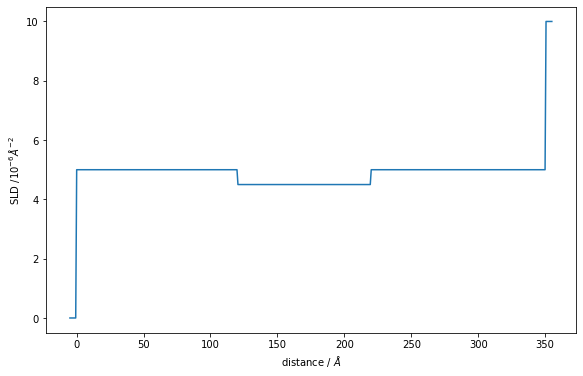

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
#notebook
plt.figure(figI)
figI+=1
plt.plot(*realStructure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [ ]:
q = np.linspace(0.005, 0.3, 70)
resolutions = [1.,3.,7.,9.]
dRScaleBys = [5,10,15,20]
# lnPosts = []
# lnPostss = []
lnEvidence1 = []
lnEvidence2 = []
figI=1
# resolution = 5.
for dRScaleBy in dRScaleBys:
#     datas=[]
    for resolution in resolutions:
        print("dRScaleBy:",dRScaleBy,"resolution:",resolution)
        realModel = ReflectModel(realStructure, bkg=3e-6, dq=resolution)
        R = realModel(q, x_err=resolution)
        sim_dR = msd.main(sim_q=q,sim_R=R)*dRScaleBy
        data = Data1D(data= (q,R,sim_dR))
        
        objective = gO(data, 3, logpExtra=logp_extra)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        lnEvidence = result["logz"][-1]
        print("thickness limited lnEvidence:",lnEvidence)
        lnEvidence1.append(lnEvidence)

        objective = gO(data, 3)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim()) #1:01:10 or 28:46 time
        DNSampler.run_nested(dlogz_init=0.05)# was 0.01
        result = DNSampler.results
        lnEvidence = result["logz"][-1]
        print("lnEvidence:",lnEvidence)
        lnEvidence2.append(lnEvidence)
#         print(lnPost)
#         lnPosts.append(lnPost)

dRScaleBy: 5 resolution: 1.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


35343it [11:01, 53.43it/s, batch: 9 | bound: 194 | nc: 1 | ncall: 171259 | eff(%): 20.637 | loglstar: -870.685 < -862.126 < -863.695 | logz: -886.491 +/-  0.281 | stop:  0.857]        


thickness limited lnEvidence: -886.4932383332437


30968it [08:45, 58.88it/s, batch: 8 | bound: 178 | nc: 1 | ncall: 162244 | eff(%): 19.087 | loglstar: -869.984 < -861.714 < -861.832 | logz: -885.908 +/-  0.282 | stop:  0.899]        


lnEvidence: -885.9481421960375
dRScaleBy: 5 resolution: 3.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


34351it [07:12, 79.40it/s, batch: 9 | bound: 140 | nc: 2 | ncall: 123622 | eff(%): 27.787 | loglstar: -243.816 < -235.399 < -236.975 | logz: -257.196 +/-  0.265 | stop:  0.845]        


thickness limited lnEvidence: -257.2096590236054


27323it [06:07, 74.39it/s, batch: 8 | bound: 118 | nc: 4 | ncall: 108130 | eff(%): 25.269 | loglstar: -243.313 < -235.438 < -237.017 | logz: -256.916 +/-  0.267 | stop:  0.884]         


lnEvidence: -256.91732197488176
dRScaleBy: 5 resolution: 7.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


35131it [20:20, 28.77it/s, batch: 8 | bound: 540 | nc: 1 | ncall: 472922 | eff(%):  7.428 | loglstar: -43.475 < -35.092 < -37.564 | logz: -60.605 +/-  0.289 | stop:  0.884]            


thickness limited lnEvidence: -60.635656577496654


32102it [11:13, 47.64it/s, batch: 7 | bound: 254 | nc: 6 | ncall: 229468 | eff(%): 13.990 | loglstar: -43.241 < -34.399 < -34.614 | logz: -61.174 +/-  0.296 | stop:  0.968]             


lnEvidence: -61.157452969393304
dRScaleBy: 5 resolution: 9.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


33644it [19:40, 28.49it/s, batch: 7 | bound: 567 | nc: 6 | ncall: 459506 | eff(%):  7.322 | loglstar: -661.443 < -652.956 < -653.070 | logz: -681.081 +/-  0.306 | stop:  0.848]         


thickness limited lnEvidence: -681.0912298258994


26950it [28:33, 15.73it/s, batch: 6 | bound: 1048 | nc: 1 | ncall: 819454 | eff(%):  3.289 | loglstar: -661.265 < -653.644 < -655.971 | logz: -681.427 +/-  0.308 | stop:  0.921]           


lnEvidence: -681.437417864298
dRScaleBy: 10 resolution: 1.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


20589it [04:51, 70.72it/s, batch: 6 | bound: 102 | nc: 2 | ncall: 101308 | eff(%): 20.323 | loglstar: -160.602 < -153.363 < -155.797 | logz: -172.912 +/-  0.250 | stop:  0.995]      


thickness limited lnEvidence: -172.92482398619418


33168it [08:05, 68.32it/s, batch: 9 | bound: 181 | nc: 1 | ncall: 161590 | eff(%): 20.526 | loglstar: -162.315 < -153.211 < -153.302 | logz: -173.095 +/-  0.247 | stop:  0.912]      


lnEvidence: -173.1017708378651
dRScaleBy: 10 resolution: 3.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


25091it [06:11, 67.53it/s, batch: 8 | bound: 121 | nc: 3 | ncall: 118308 | eff(%): 21.208 | loglstar: -0.965 <  7.146 <  5.842 | logz: -10.137 +/-  0.233 | stop:  0.929]             


thickness limited lnEvidence: -10.110825225586273


30514it [06:42, 75.90it/s, batch: 8 | bound: 136 | nc: 1 | ncall: 132371 | eff(%): 23.052 | loglstar: -1.166 <  7.363 <  7.304 | logz: -10.594 +/-  0.236 | stop:  0.873]             


lnEvidence: -10.582653522585327
dRScaleBy: 10 resolution: 7.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


32670it [2:02:41,  4.44it/s, batch: 8 | bound: 1752 | nc: 2 | ncall: 1637232 | eff(%):  1.995 | loglstar: 52.904 < 62.010 < 60.443 | logz: 40.734 +/-  0.252 | stop:  0.884]          


thickness limited lnEvidence: 40.71526016826861


32303it [20:23, 26.40it/s, batch: 8 | bound: 475 | nc: 11 | ncall: 513623 | eff(%):  6.289 | loglstar: 53.303 < 62.243 < 62.106 | logz: 41.022 +/-  0.253 | stop:  0.935]             


lnEvidence: 41.01100047884921
dRScaleBy: 10 resolution: 9.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


21976it [1:13:54,  4.96it/s, batch: 5 | bound: 2560 | nc: 3 | ncall: 1981210 | eff(%):  1.109 | loglstar: -101.196 < -93.067 < -100.551 | logz: -114.376 +/-  0.262 | stop:  0.998]      


thickness limited lnEvidence: -114.35333093091063


33108it [07:33, 72.97it/s, batch: 6 | bound: 170 | nc: 1 | ncall: 149873 | eff(%): 22.091 | loglstar: -102.040 < -91.379 < -91.630 | logz: -114.497 +/-  0.261 | stop:  0.858]        


lnEvidence: -114.47440075640644
dRScaleBy: 15 resolution: 1.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


29730it [06:47, 73.04it/s, batch: 8 | bound: 160 | nc: 1 | ncall: 142881 | eff(%): 20.808 | loglstar: -50.183 < -41.397 < -41.513 | logz: -58.230 +/-  0.223 | stop:  0.911]          


thickness limited lnEvidence: -58.25286210097383


31116it [07:25, 69.87it/s, batch: 8 | bound: 174 | nc: 4 | ncall: 159521 | eff(%): 19.506 | loglstar: -50.216 < -41.405 < -41.474 | logz: -58.686 +/-  0.226 | stop:  0.868]          


lnEvidence: -58.693272706038876
dRScaleBy: 15 resolution: 3.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


30988it [07:28, 69.14it/s, batch: 9 | bound: 166 | nc: 1 | ncall: 153398 | eff(%): 20.201 | loglstar: 24.201 < 32.884 < 32.816 | logz: 17.756 +/-  0.213 | stop:  0.870]              


thickness limited lnEvidence: 17.723082482598887


18982it [05:00, 63.24it/s, batch: 7 | bound: 92 | nc: 1 | ncall: 94490 | eff(%): 20.089 | loglstar: 25.369 < 32.684 < 25.894 | logz: 17.521 +/-  0.215 | stop:  0.996]                


lnEvidence: 17.53297186821069
dRScaleBy: 15 resolution: 7.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


29335it [1:35:43,  5.11it/s, batch: 6 | bound: 1384 | nc: 1 | ncall: 1368895 | eff(%):  2.143 | loglstar: 51.144 < 60.719 < 60.588 | logz: 42.368 +/-  0.226 | stop:  0.842]         


thickness limited lnEvidence: 42.352285684005714


23111it [1:48:03,  3.56it/s, batch: 6 | bound: 1493 | nc: 1 | ncall: 1422953 | eff(%):  1.624 | loglstar: 51.071 < 60.544 < 59.177 | logz: 42.493 +/-  0.224 | stop:  0.957]         


lnEvidence: 42.470821909647526
dRScaleBy: 15 resolution: 9.0
csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


27900it [1:08:15,  6.81it/s, batch: 7 | bound: 2255 | nc: 3 | ncall: 1740062 | eff(%):  1.603 | loglstar: -15.991 < -6.823 < -7.028 | logz: -26.067 +/-  0.239 | stop:  0.891]             


thickness limited lnEvidence: -26.065555798391184


24201it [3:57:27, 148.95s/it, batch: 8 | bound: 6663 | nc: 33065 | ncall: 5050667 | eff(%):  0.479 | loglstar: -16.353 < -8.957 < -7.028 | logz: -26.081 +/-  0.238 | stop:  1.114]  

In [ ]:
f=open("dDqDR2Dupdated2.txt","w+")
f.write("limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence1:
    f.write(str(lnEvidence)+"\n")
f.write("\nnot limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence2:
    f.write(str(lnEvidence)+"\n")
f.close()

26499it [24:55, 17.72it/s, batch: 7 | bound: 706 | nc: 8 | ncall: 646207 | eff(%):  4.101 | loglstar: -202.191 < -195.105 < -197.037 | logz: -220.134 +/-  0.292 | stop:  0.952]         
-220.11328681456592

28379it [08:30, 55.62it/s, batch: 8 | bound: 181 | nc: 6 | ncall: 161880 | eff(%): 17.531 | loglstar: 1000.415 < 1008.232 < 1007.220 | logz: 982.787 +/-  0.292 | stop:  0.987]          
982.7887810159078

32388it [24:41, 21.86it/s, batch: 8 | bound: 716 | nc: 6 | ncall: 590509 | eff(%):  5.485 | loglstar: 1075.286 < 1083.785 < 1081.905 | logz: 1055.241 +/-  0.310 | stop:  0.996]         
1055.2684365805314

30559it [4:44:11,  1.79it/s, batch: 7 | bound: 9951 | nc: 9 | ncall: 7637451 | eff(%):  0.400 | loglstar: -123.375 < -115.445 < -116.614 | logz: -146.484 +/-  0.325 | stop:  0.954]            
-146.47705209627895

30163it [13:24, 37.49it/s, batch: 8 | bound: 316 | nc: 3 | ncall: 287583 | eff(%): 10.488 | loglstar: -202.911 < -195.011 < -196.521 | logz: -220.609 +/-  0.294 | stop:  0.896]         
-220.60610280345477

28286it [08:12, 57.44it/s, batch: 8 | bound: 173 | nc: 3 | ncall: 156091 | eff(%): 18.121 | loglstar: 1000.488 < 1008.240 < 1007.316 | logz: 982.981 +/-  0.291 | stop:  0.962]          
982.9960603373407

28828it [11:10, 42.98it/s, batch: 7 | bound: 262 | nc: 13 | ncall: 232396 | eff(%): 12.405 | loglstar: 1075.951 < 1083.723 < 1081.587 | logz: 1055.021 +/-  0.312 | stop:  0.982]         
1055.0312970246378

27767it [30:19, 15.26it/s, batch: 6 | bound: 879 | nc: 7 | ncall: 707327 | eff(%):  3.926 | loglstar: -122.960 < -115.814 < -118.256 | logz: -146.916 +/-  0.329 | stop:  0.958]          
-146.91675261007052

29402it [08:33, 57.22it/s, batch: 8 | bound: 177 | nc: 4 | ncall: 157628 | eff(%): 18.653 | loglstar: -202.548 < -195.020 < -196.058 | logz: -220.605 +/-  0.294 | stop:  0.979]         
-220.6032067872486

30570it [08:33, 59.56it/s, batch: 8 | bound: 171 | nc: 2 | ncall: 151998 | eff(%): 20.112 | loglstar: 1000.298 < 1008.302 < 1007.287 | logz: 982.565 +/-  0.294 | stop:  0.917]          
982.54792841728

31217it [10:50, 48.03it/s, batch: 8 | bound: 245 | nc: 2 | ncall: 221857 | eff(%): 14.071 | loglstar: 1075.649 < 1083.508 < 1081.140 | logz: 1054.841 +/-  0.312 | stop:  0.874]         
1054.832846010915

31648it [3:08:55,  2.79it/s, batch: 8 | bound: 7087 | nc: 4 | ncall: 5426582 | eff(%):  0.583 | loglstar: -123.704 < -115.501 < -117.517 | logz: -146.624 +/-  0.325 | stop:  0.911]            
-146.635041601231

27858it [13:01, 35.64it/s, batch: 8 | bound: 313 | nc: 2 | ncall: 286177 | eff(%):  9.735 | loglstar: -202.557 < -195.077 < -195.935 | logz: -220.541 +/-  0.294 | stop:  0.950]         
-220.51950736917618

29685it [08:45, 56.49it/s, batch: 8 | bound: 186 | nc: 1 | ncall: 167036 | eff(%): 17.772 | loglstar: 1000.284 < 1008.179 < 1006.634 | logz: 982.917 +/-  0.291 | stop:  0.947]
982.9139570644866

32599it [08:38, 62.89it/s, batch: 8 | bound: 175 | nc: 11 | ncall: 153989 | eff(%): 21.170 | loglstar: 1075.323 < 1083.736 < 1081.824 | logz: 1054.970 +/-  0.311 | stop:  0.858]
1054.9575362870723

33744it [2:08:35,  4.37it/s, batch: 8 | bound: 4335 | nc: 1 | ncall: 3416253 | eff(%):  0.988 | loglstar: -123.740 < -115.761 < -117.602 | logz: -147.612 +/-  0.332 | stop:  0.821]
-147.6220194411551

17

-220.11328681456592, 982.7887810159078, 1055.2684365805314, -146.47705209627895, -220.60610280345477, 982.9960603373407, 1055.0312970246378, -146.91675261007052, -220.6032067872486, 982.54792841728, 1054.832846010915, -146.635041601231, -220.51950736917618, 982.9139570644866, 1054.9575362870723, -147.6220194411551

In [ ]:
%%time

ha_s = ["left", "center", "center", "right"]

print("thickness limited ln(Evidence):",lnEvidence1)
print("not thickness limited ln(Evidence):",lnEvidence2)

zs= np.array(lnEvidence1).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):
    for j in range(len(resolutions)):
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();
#--------

zs= np.array(lnEvidence2).reshape(len(resolutions), len(dRScaleBys)).transpose()
plt.figure(figI)
figI+=1
plt.contour(dRScaleBys,resolutions,zs,alpha=0.5);
plt.contourf(dRScaleBys,resolutions,zs,alpha=0.3);
plt.colorbar();
for i in range(len(dRScaleBys)):
    for j in range(len(resolutions)):
        plt.scatter(dRScaleBys[i],resolutions[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate(zs[j][i],(dRScaleBys[i],resolutions[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
# for x in dRScaleBys:
#     for y in resolutions:
#         plt.scatter(x,y,c="red",marker="x");
plt.ylabel("dq");
plt.xlabel("dR scaled by");
plt.title("not thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
plt.tight_layout();
plt.show();

thickness limited ln(Evidence): [-886.2338759719516, -256.8224918348395, -61.03303894872692, -682.6266779760213, -173.0746737843894, -10.302971524391873, 40.878851270732426, -114.4072512583621, -58.64780510695973, 17.468412975171937, 42.341773042336406, -26.07731100106868, -27.701438332130166, 17.923427521647163, 34.37910322948846, -4.680316380923956]
not thickness limited ln(Evidence): [-886.3654858783067, -256.92328393233277, -61.02068196011918, -681.4610409074794, -173.05969495127744, -10.485837192186086, 40.75223150230152, -114.68229572753494, -58.44818983219997, 17.37091701476931, 42.5108219989175, -26.765799975725457, -27.847024452945774, 17.7413881949897, 34.524598968004895, -4.491294767664335]

In [ ]:
# for objective1,objective2 in zip(objectives1,objectives2):
#     plt.figure(figI)
#     figI+=1

#     plt.subplot(2,2,1).set_title("data plotted for limited max thickness")
#     fig, ax = objective1.plot()
#     plt.subplot(2,2,2).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective1.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');

#     plt.subplot(2,2,3).set_title("data plotted for limited max thickness")
#     fig, ax = objective2.plot()
#     plt.subplot(2,2,4).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective2.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');
